# Open AI gym example
This code shows the use of open AI with chaos theory

### Section 1
Creating the open AI gym simulation

In [27]:
import sys
import gym
import gym
from gym import logger as gymlogger
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

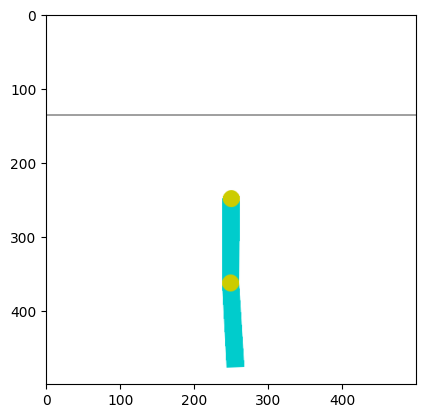

In [26]:
env = gym.make("Acrobot-v1",render_mode="rgb_array")
observation, info = env.reset()
show=False
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if show:
        rendered=env.render()
        plt.imshow(rendered)
        plt.pause(0.05)
    if terminated or truncated:
        observation, info = env.reset()
plt.imshow(env.render())
plt.show()
env.close()


### Section 2

Chaotic model

In 3D we have a chaotic model looking like the following:

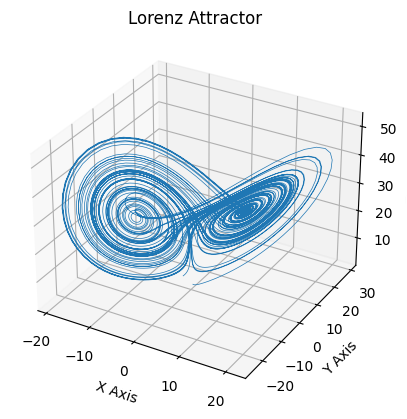

In [37]:
prandtl = 10 
rho = 28
beta = 8/3

def lorenz_attr(x, y, z):
    x_dot = prandtl*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - beta*z
    return x_dot, y_dot, z_dot

dt = 0.01
num_steps = 10000

xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)
xs[0], ys[0], zs[0] = (0., 1., 1.05)

for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz_attr(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In 2D we can strip away detail and generate an ossilation

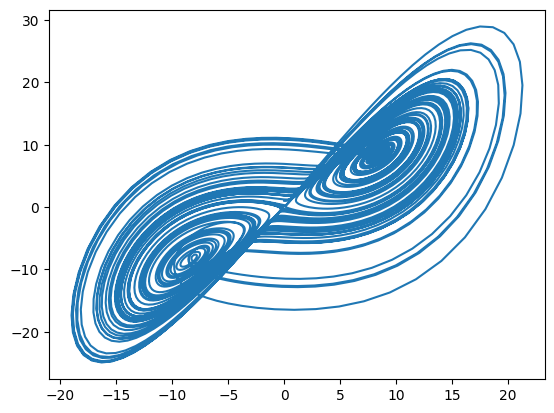

In [38]:
dt = 0.01
num_steps = 10000

xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)
xs[0], ys[0], zs[0] = (0., 1., 1.05)

for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz_attr(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

plt.plot(xs,ys)
plt.show()